# SQD for water on IBM

In [25]:
import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of

import qiskit
from qiskit_aer import AerSimulator  # For MPS Simulator.

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [19]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

In [26]:
mol = pyscf.gto.Mole()
mol.build(
    atom=of.chem.geometry_from_pubchem("water"),
    basis="6-31g",
    symmetry="C2v",
)

In [27]:
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

In [28]:
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -75.9833863945272
CASCI E = -76.1214381230091  E(CI) = -85.2058026349851  S^2 = 0.0000000


In [29]:
exact_energy

-76.12143812300907

## Ansatz

In [30]:
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -76.11986618990883  E_corr = -0.1364797953815957


In [33]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister


n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
# circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

# Measure all qubits.
circuit.measure_all()

In [34]:
circuit.draw(fold=-1)

┌───────────────────┐ ░ ┌─┐                                                                           
    q_0: ┤0                  ├─░─┤M├───────────────────────────────────────────────────────────────────────────
         │                   │ ░ └╥┘┌─┐                                                                        
    q_1: ┤1                  ├─░──╫─┤M├────────────────────────────────────────────────────────────────────────
         │                   │ ░  ║ └╥┘┌─┐                                                                     
    q_2: ┤2                  ├─░──╫──╫─┤M├─────────────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║ └╥┘┌─┐                                                                  
    q_3: ┤3                  ├─░──╫──╫──╫─┤M├──────────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║ └╥┘┌─┐                                                               
    q_4: ┤4                  ├─░──╫──╫──╫──╫─┤M├───────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║ └╥┘┌─┐                                                            
    q_5: ┤5                  ├─░──╫──╫──╫──╫──╫─┤M├────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                                                         
    q_6: ┤6                  ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                      
    q_7: ┤7                  ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                   
    q_8: ┤8                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                
    q_9: ┤9                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                             
   q_10: ┤10                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                          
   q_11: ┤11                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                       
   q_12: ┤12                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────
         │   Hartree_fock_jw │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                    
   q_13: ┤13                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                 
   q_14: ┤14                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                              
   q_15: ┤15                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                           
   q_16: ┤16                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        
   q_17: ┤17                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──

## Run on hardware

### Prepare to run on hardware

In [35]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('measure', 26), ('x', 10), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('measure', 26), ('x', 10), ('barrier', 1)])


### Run the circuit

In [37]:
simulator = AerSimulator(method="matrix_product_state")

In [38]:
result = simulator.run(isa_circuit, shots=1000)

In [41]:
counts = result.result().get_counts()
counts

{'00000000111110000000011111': 1000}

In [11]:
import numpy as np
from qiskit_addon_sqd.counts import generate_bit_array_uniform

# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=10_000)
# primitive_result = job.result()
# pub_result = primitive_result[0]
# bit_array = pub_result.data.meas

rng = np.random.default_rng(24)
bit_array = generate_bit_array_uniform(10_000, num_orbitals * 2, rand_seed=rng)

## Post-process results

In [12]:
from functools import partial

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 1
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -74.8958987390684
		Subspace dimension: 202500
Iteration 2
	Subsample 0
		Energy: -76.06977781100993
		Subspace dimension: 206116
Iteration 3
	Subsample 0
		Energy: -76.11774246867277
		Subspace dimension: 242064
Iteration 4
	Subsample 0
		Energy: -76.11912153874825
		Subspace dimension: 286225
Iteration 5
	Subsample 0
		Energy: -76.11958171875632
		Subspace dimension: 324900


Exact energy: -76.12144 Ha
SQD energy: -76.11958 Ha
Absolute error: 0.00186 Ha


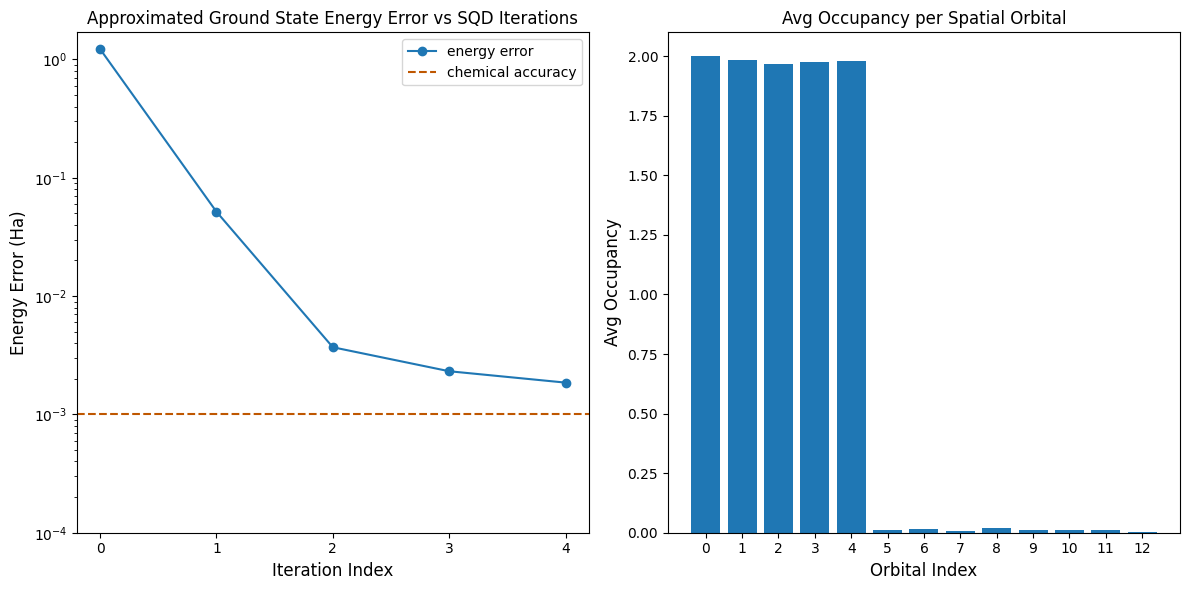

In [13]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f} Ha")
print(f"SQD energy: {min_e[-1]:.5f} Ha")
print(f"Absolute error: {e_diff[-1]:.5f} Ha")
plt.tight_layout()
plt.show()